# Overview

This notebook contains code to scrape the Top 100 books from the Gutenberg project and then subquently evaluate the difficulty of those books. More specifically, the notebook is divided into two parts:
1. In the first half, we scrape the Project Gutenberg website for the entire texts of the Top 100 Books.
2. In the second half, we predict the readability of this scraped text and use these predictions to recomend appropriate texts to teachers.

Before doing anything, let's first download everything listed in the `requirements.txt` file:

In [7]:
!pip install -r ./requirements.txt

     |████████████████████████████████| 2.8 MB 4.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.4 MB/s 
     |████████████████████████████████| 636 kB 40.6 MB/s 
     |████████████████████████████████| 895 kB 38.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Part I: Data Scraping

## Overview of Approach

Before imediately diving into the code, it's useful to first go over how book information of the Project Gutenberg website is structured:
  - The information of each book listed on the Project Gutenberg website is placed inside a `div` element with the `booklink` class. Within these `booklink` elements, the Title and Author of the book are listed, as well as a link to another individual webpage for that specific book.
  - The individual webpage for a given book contains a list of links to different versions of that book (e.g. an Epub version, a Plain Text version, a Kindle version, etc.). 
  - Importantly, almost all books list an *HTML version* of the book - this is simply the text of the book written as a simple HTML page. The only books which tend not to to HTML versions are those books which are 'highly visual'; for example, the listing for [*Calculus Made Easy* by Silvanus P. Thompson](https://www.gutenberg.org/ebooks/33283) does not have an HTML version, since most of this book consists of equations which cannot be rendered in HTML. For the purposes of this scraping exercise, books which did not have a listed HTML version were not scraped.
  - Conveniently, for those texts with an HTML version, all of the text of the book is included inside of `p` tags - this means that the entirety of the text can be scraped from an HTML version of a book just by grapping the content of inside all of the `p` tags on that page.


With this information about the structure of the Project Gutenberg website in mind, scraping the Gutenberg website for the Top 100 texts consisted of two steps:
1. Part A: Create a Dataframe which contains the Title, Author, and link to the HTML version of the Top `n` books (where `n` is a user-specified integer). Those books without an HTML version are *not* added to this dataframe and are ignored.
2. Part B: Visit all of the links to the HTML versions of books listed in the previous dataframe; for each HTML version of the book, scrape the text found in all of the `p` tags and combine these into a single string.

Now that we've outlined our data scraping approach, let's now go into the code.

## Part A: Creating a Dataframe of Links to HTML Versions of Books

Imports required for the data scraping part of this notebook:

In [8]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
from math import ceil
import string 

Define the 'base url' of the Gutenbreg website which we'll scrape, as well as the name of the parser we want to use with Beautiful Soup:

In [9]:
BASE_URL = "https://www.gutenberg.org"
PARSER_NAME = 'lxml'

Let's now define our function(s) to create this table of HTML version links:

In [10]:
def get_book_info(num_2_get):
  
  # Generate URLs of webpages to visit by appending extension to end of base directory:
  start_url = BASE_URL + "/ebooks/search/?sort_order=downloads"

  # Initialise lists to store author, title, and url information for each book:
  author_list, title_list, url_list = [], [], []

  # Initialise loop variables:
  current_url = start_url
  num_books = 0 
  num_books_checked = 0

  # Keep going until we get specified number of books:
  while num_books < num_2_get:
    # Get soup of current URL:
    soup = BeautifulSoup(requests.get(current_url).text, PARSER_NAME)

    # Get booklink elements off this page:
    current_el = [x for x in soup.find_all(class_='booklink')]

    # Determine the maximum number of books we need to take from this page:
    num_2_take = min(len(current_el), num_2_get - num_books)

    # Get book 'id' of each book on page - the Gutenberg website has an integer
    # ID associated with each book:
    current_id = [x.a['href'].split('/')[-1] for x in current_el]

    # Get the Title, Author and URLs for each book which has an HTML version:
    (authors_i, titles_i, urls_i) = process_booklinks(current_el, current_id, num_2_take)

    # Append to our lists:
    author_list += authors_i
    title_list += titles_i
    url_list += urls_i

    # Update how many books we've collected and checked from this page:
    num_books += len(authors_i)
    num_books_checked += len(current_id)

    # Update our current_url so that we go to the next page:
    current_url = start_url + f"&start_index={num_books_checked+1}"

  # Now that we have a list of num_to_get books, let's convert all this information
  # to a dataframe:
  book_df = pd.DataFrame.from_dict({'title': title_list,
                                    'author': author_list,
                                    'url': url_list})
  return book_df

The above function calls the below helper function, which simply processes all of the information within each `booklink` element listed on a given page: 

In [11]:
# Regex to remove special characters at end of title string:
SPECCHAR_REGEX = re.compile('(\\n)|(\\r)|(\\r\\n)')

def process_booklinks(bl_element, book_id, num_2_take):

  # Create urls for corresponding books by using the Project Gutenberg ID of each book:
  book_urls = [BASE_URL + "/ebooks/" + str(id) for id in book_id]

  # Get soups for each book's unique page:
  soup_list = [BeautifulSoup(requests.get(url).text, PARSER_NAME) for url in book_urls]

  # Find links associated with "HTML (Original)" text links on page:
  html_ext = [s.find('a', text="Read this book online: HTML (original)") for s in soup_list]

  # Get lists of Authors, Titles, and links for books with HTML versions available:
  authors, titles, urls = [], [], []

  # Iterate over each book's unique page:
  for i, ext in enumerate(html_ext):

    # Only add book if it has an HTML version of the book is available AND
    # if we still haven't taken num_2_take books:
    if ext is not None and len(authors) < num_2_take:

      # Get title from list of booklinks:
      title_i = bl_element[i].find(class_="title").contents[0]

      # Remove 'special characters' from title of books:
      title_i = re.sub(SPECCHAR_REGEX, '', title_i)
      titles.append(title_i)

      # Get author from list of booklinks - need to check if book has a non-empty
      # author tag (i.e. the author is anonymous):
      author_i = bl_element[i].find(class_="subtitle")
      author_i = author_i.contents[0] if author_i is not None else "Anonymous"
      authors.append(author_i)

      # Get URL of HTML version of text:
      urls.append(BASE_URL + str(ext['href']))
      
  # Return these lists:
  return (authors, titles, urls)

Let's now call our newly defined function to scrape the top 100 books (with an HTML version) - this takes about a minute:

In [12]:
num_2_get = 100
book_df = get_book_info(num_2_get)

Let's see what this Dataframe looks like:

In [13]:
book_df

,title,author,url
0,Pride and Prejudice,Jane Austen,https://www.gutenberg.org/files/1342/1342-h/13...
1,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,https://www.gutenberg.org/files/84/84-h/84-h.htm
2,Alice's Adventures in Wonderland,Lewis Carroll,https://www.gutenberg.org/files/11/11-h/11-h.htm
3,The Adventures of Sherlock Holmes,Arthur Conan Doyle,https://www.gutenberg.org/files/1661/1661-h/16...
4,"Moby Dick; Or, The Whale",Herman Melville,https://www.gutenberg.org/files/2701/2701-h/27...
...,...,...,...
95,A Journal of the Plague Year,Daniel Defoe,https://www.gutenberg.org/files/376/376-h/376-...
96,The Sign of the Four,Arthur Conan Doyle,https://www.gutenberg.org/files/2097/2097-h/20...
97,A Portrait of the Artist as a Young Man,James Joyce,https://www.gutenberg.org/files/4217/4217-h/42...
98,The Marching Morons,C. M. Kornbluth,https://www.gutenberg.org/files/51233/51233-h/...


## Part B: Scraping Text Inside `<p>` Tags of HTML Books

Now that we have a dictionary which contains links to the HTML version of each book we want to scrape, let's now actually scrape the text contained with the HTML version of each book. To do this, we use the following function:

In [14]:
# First, let's define some regular expressions which we'll use to 'clean up'
# the text we scrape from each <p> tag:
punct_regex = re.escape(string.punctuation)
char_regex = re.compile('([^ [a-zA-Z0-9]])&([^{}])'.format(punct_regex))
specchar_regex = re.compile('(\\n)|(\\r)|(\\r\\n)')
tag_regex = re.compile('(\<\d\>)|(\</\d\>)')
space_regex = re.compile(' +')

def get_text(book_df):
  # Initialise list to store text:
  text_list = []

  # Iterate over urls in dataframe:
  for url in book_df['url']:
    # Get soup of page:
    soup = BeautifulSoup(requests.get(url).text.encode("ascii", 'ignore'), PARSER_NAME)

    # Initialise string to contain entire text:
    text_i = ''

    # Iterate over paragraphs on page and add to text:
    all_paras = soup.find_all('p')
    for p in all_paras:

      # Remove unwanted characters using regular expressions:
      text_chunk = re.sub(char_regex, ' ', p.get_text())
      text_chunk = re.sub(specchar_regex, ' ', text_chunk)
      text_chunk = re.sub(tag_regex, ' ', text_chunk)

      # Replace multiple spaces with single spaces:
      text_chunk = re.sub(space_regex, ' ', text_chunk)
      if len(text_chunk) > 0:
        # Add spaces if required:
        text_chunk = ' '+text_chunk if text_chunk[0]!=' ' else text_chunk
        
        # Append paragraph to string:
        text_i += text_chunk

    # Append i'th text to list:
    text_list.append(text_i)

  # Add text list as new column to dataframe:
  book_df['text'] = text_list
  
  return book_df

Let's now call this function to get the entire text for each book listed in our `book_df` - this takes about two minutes:

In [15]:
text_df = get_text(book_df)

Let's see what this dataframe looks like:

In [16]:
text_df

,title,author,url,text
0,Pride and Prejudice,Jane Austen,https://www.gutenberg.org/files/1342/1342-h/13...,"It is a truth universally acknowledged, that ..."
1,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,https://www.gutenberg.org/files/84/84-h/84-h.htm,"To Mrs. Saville, England. St. Petersburgh, D..."
2,Alice's Adventures in Wonderland,Lewis Carroll,https://www.gutenberg.org/files/11/11-h/11-h.htm,Alice was beginning to get very tired of sitt...
3,The Adventures of Sherlock Holmes,Arthur Conan Doyle,https://www.gutenberg.org/files/1661/1661-h/16...,To Sherlock Holmes she is always the woman. I...
4,"Moby Dick; Or, The Whale",Herman Melville,https://www.gutenberg.org/files/2701/2701-h/27...,CONTENTS ETYMOLOGY. EXTRACTS (Supplied ...
...,...,...,...,...
95,A Journal of the Plague Year,Daniel Defoe,https://www.gutenberg.org/files/376/376-h/376-...,"It was about the beginning of September, 1664..."
96,The Sign of the Four,Arthur Conan Doyle,https://www.gutenberg.org/files/2097/2097-h/20...,Sherlock Holmes took his bottle from the corn...
97,A Portrait of the Artist as a Young Man,James Joyce,https://www.gutenberg.org/files/4217/4217-h/42...,"“Et ignotas animum dimittit in artes.” Ovid,..."
98,The Marching Morons,C. M. Kornbluth,https://www.gutenberg.org/files/51233/51233-h/...,By C. M. KORNBLUTH Illustrated by DON SIBLEY ...


Let's now save this to a CSV:

In [17]:
text_df.to_csv('gutenberg_texts.csv')

# Part II: BERT Predictions with Gutenberg Data


## Overview of this Section

We now have a dataframe which contains the texts of the Top 100 Proejct Gutenberg Books, let's now estimate the readability of these pieces of text. 

Obviously, these scraped texts are much longer than the maximum token length of 500 which BERT can take as an input. Because of this limitation, each text input is first *'cut up'* into sub-strings of size `MAX_LEN`; the readability of each sub-string is then evaluated. 

This means that for each book in our scraped dataset, we'll have an **entire distribution of readability values** associated with each sub-string within that text. From these distributions, we can compute statistical quantities such as the mean and variance of the readability of each text.


## BERT Predictions



Let's first import all the packages we need for this section:

In [18]:
# PyTorch and Numpy imports:
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np

# HuggingFace imports:
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Misc libraries:
import os

Let's set the device used by PyTorch?

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cuda


Let's specify the random seed used by PyTorch:

In [20]:
RANDOM_SEED = 32
torch.manual_seed(RANDOM_SEED)

Let's now download the finetuned Bert model weights from [my public data set on Kaggle](https://www.kaggle.com/matthewabilton/finetuned-bert-readability). In order for this code cell to work, you **must add your `kaggle.json` API key to the current directory this notebook is running in** - [see here](https://github.com/Kaggle/kaggle-api/issues/15) for more details on this.

In [21]:
if not os.path.exists('/root/.kaggle/'):
    os.makedirs('/root/.kaggle/')
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d matthewabilton/finetuned-bert-readability
!unzip finetuned-bert-readability.zip

 98% 230M/236M [00:05<00:00, 37.8MB/s]
100% 236M/236M [00:05<00:00, 43.5MB/s]
Archive:  finetuned-bert-readability.zip
  inflating: best_model/config.json  
  inflating: best_model/pytorch_model.bin  
  inflating: tokenizer/special_tokens_map.json  
  inflating: tokenizer/tokenizer_config.json  
  inflating: tokenizer/vocab.txt     


Now that we've downloaded, our finetuned model and tokenizer, let's load the tokenizer into memory and specify the maximum sub-string length:

In [22]:
MAX_LEN = 250
load_dir = "./tokenizer"
TOKENIZER = DistilBertTokenizer.from_pretrained(load_dir)

The next few code cells are, more or less, copied/slightly modified from the IPython notebook I used to train my BERT model - see `BERT Model Training.ipynb` in the folder `[1] Train BERT Model` for a more complete explanation of this code. 

The only difference to note here is that we've added a `text_id` tensor which stores an integer between `0` and `99`, where each text in the dataset has a unique integer associated with it (i.e. it's an integer by which we can identify which text a sub-string comes from).

In [23]:
# Define a custom dataset object to store scraped data:
class GutenbergData(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item_i = self.dataset[idx]
        dict_i = {"id": item_i[0],
                  "mask": item_i[1],
                  "text_id": item_i[2]}
        return dict_i

In [24]:
# Processes each chunk of tokenized text so it can be 'understood' by BERT:
def process_chunks(id_chunk, mask_chunk, max_len, start_id=101, end_id=102):
  # Add start and stop IDs:
  id_chunk = torch.cat([torch.tensor([start_id]), id_chunk, torch.tensor([end_id])])
  mask_chunk = torch.cat([torch.ones(1), mask_chunk, torch.ones(1)])
  # Pad chunks if required:
  if len(id_chunk) < max_len:
    pad_len = max_len - len(id_chunk)
    id_chunk = torch.cat([id_chunk, torch.zeros(pad_len)])
    mask_chunk = torch.cat([mask_chunk, torch.zeros(pad_len)])
  return (id_chunk, mask_chunk)


In [25]:
# Code to create dataset object from our scraped dataframe:
def create_dataset(text_df, tokenizer, max_len):
  X_id, X_mask, text_id = [], [], []
  for i, text in enumerate(text_df["text"]):
    id_list, mask_list = [], []
    tokens = tokenizer.encode_plus(text, add_special_tokens=False, return_tensors='pt')
    if (i+1)%10==0 and i>0:
      print(f'Finished tokenizing {i+1}/{text_df.shape[0]} texts.')
    ids = tokens["input_ids"][0].split(max_len-2)
    masks = tokens["attention_mask"][0].split(max_len-2)
    for id_chunk, mask_chunk in zip(ids, masks):
      id_chunk, mask_chunk = process_chunks(id_chunk, mask_chunk, max_len)
      id_list.append(id_chunk), mask_list.append(mask_chunk)
    X_id.append(torch.stack(id_list, dim=0))
    X_mask.append(torch.stack(mask_list, dim=0))
    text_id.append(i*torch.ones(len(ids)))
  X_id = torch.cat(X_id, axis=0)
  X_mask = torch.cat(X_mask, axis=0)
  text_id = torch.cat(text_id, axis=0)
  # Ensure tensors are all integer values:
  X_id = torch.as_tensor(X_id, dtype=torch.int64)
  X_mask = torch.as_tensor(X_mask, dtype=torch.int64)
  text_id = torch.as_tensor(text_id, dtype=torch.int64).reshape((X_id.shape[0], 1))
  # Place in dataset object:
  dataset = TensorDataset(X_id, X_mask, text_id)
  dataset = GutenbergData(dataset)
  return dataset

Let's now call the above code to create a dataset object from our scraped dataframe - this takes about five minutes:

In [26]:
text_ds = create_dataset(text_df, TOKENIZER, MAX_LEN)

Token indices sequence length is longer than the specified maximum sequence length for this model (154215 > 512). Running this sequence through the model will result in indexing errors


Finished tokenizing 10/100 texts.
Finished tokenizing 20/100 texts.
Finished tokenizing 30/100 texts.
Finished tokenizing 40/100 texts.
Finished tokenizing 50/100 texts.
Finished tokenizing 60/100 texts.
Finished tokenizing 70/100 texts.
Finished tokenizing 80/100 texts.
Finished tokenizing 90/100 texts.
Finished tokenizing 100/100 texts.


Now that we have a PyTorch dataset object, let's create a Dataloader object from it:

In [27]:
batch_size = 32
text_dl = DataLoader(text_ds,
                     batch_size=batch_size,
                     shuffle=False)

Now let's create a Bert model object - once again, this code is basically the same as that which appears in BERT Model Training.ipynb:

In [28]:
class BertModel():
  def __init__(self, load_dir):
    self.model = DistilBertForSequenceClassification.from_pretrained(load_dir)
    # Move model to device:
    self.model.to(device)
  
  def predict(self, id, att_mask, text_id):
    # Just evaluating here, no training - no need for gradients to perform backprop:
    with torch.no_grad():
      # Make sure model is in evaluation mode, rather than training mode:
      if self.model.training:
        self.model.eval()
      # Move inputs to device:
      id, att_mask = id.to(device), att_mask.to(device)
      # Make prediction with BERT model:
      logits = self.model(input_ids=id, attention_mask=att_mask)["logits"]
      # Convert output to NumPy array:
      logits = logits.cpu().numpy()
      # Append text_id to each prediction:
      pred = np.concatenate((text_id, logits), axis=1)
      return pred

We can now create our BERT model from our pretrained weights:

In [29]:
load_dir = "./best_model"
bert_model = BertModel(load_dir)

Let's now use this BERT model to predict the difficulty of the text chunks in the dataloader - this takes approximately 15 minutes on a Tesla T4 GPU running on Google Colab:

In [30]:
# Initialise array to store results:
pred_array = np.array([])

# Iterate over samples in dataloader:
for i, d in enumerate(text_dl):
  
  # Print progress to user:
  if (i+1)%100==0:
    print(f"Batch {i+1} out of {len(text_dl)}.")
  
  # Make prediction:
  pred_i = bert_model.predict(d["id"], d["mask"], d["text_id"])

  # Store result in array:
  pred_array = np.vstack((pred_array, pred_i)) if pred_array.size>0 else pred_i

# Place predicted values in dataframe:
pred_df = pd.DataFrame(pred_array, columns=["text_id", "pred"])

# Make sure text_id's are integers:
pred_df["text_id"] = pred_df["text_id"].apply(lambda x: int(x))

# Save dataframe:
pred_df.to_csv('gutenberg_pred.csv')

Batch 100 out of 1964.
Batch 200 out of 1964.
Batch 300 out of 1964.
Batch 400 out of 1964.
Batch 500 out of 1964.
Batch 600 out of 1964.
Batch 700 out of 1964.
Batch 800 out of 1964.
Batch 900 out of 1964.
Batch 1000 out of 1964.
Batch 1100 out of 1964.
Batch 1200 out of 1964.
Batch 1300 out of 1964.
Batch 1400 out of 1964.
Batch 1500 out of 1964.
Batch 1600 out of 1964.
Batch 1700 out of 1964.
Batch 1800 out of 1964.
Batch 1900 out of 1964.


Let's have a look at the dataframe we've created here:

In [31]:
pred_df

,text_id,pred
0,0,-1.121812
1,0,-1.021032
2,0,-1.131768
3,0,-0.568699
4,0,-1.216154
...,...,...
62822,99,-1.340375
62823,99,-1.948476
62824,99,-1.847092
62825,99,-1.369931


## Averaging Over Sub-Strings of Each Text

At this point, we now have a dataframe which contains the readability values associated with each sub-string of each text we've scraped - in other words, we have a *distribution* of of readabilty scored associated with each text.

To see what I mean by this, let's plot a histogram of one of the texts we've processed:





In [32]:
# Plotting function imports:
import matplotlib.pyplot as plt
import seaborn as sns

# Function which plots the readability distribution of a specified book:
def plot_difficulty_dist(book_idx):
  book_mask = pred_df["text_id"] == book_idx
  book_pred = pred_df.loc[book_mask, 'pred']
  fig, ax1 = plt.subplots()
  plt.xlabel('Difficulty')
  sns.kdeplot(data=book_pred, ax=ax1, color='r', fill=True)
  ax2 = ax1.twinx()
  sns.histplot(data=book_pred, ax=ax2, binwidth=0.1)
  sns.set_style("darkgrid")

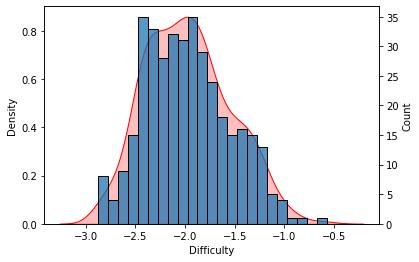

In [33]:
# Let's plot the readability distribution of the text with text_id==1:
book_idx = 1
plot_difficulty_dist(book_idx)

With this all in mind, let's now compute a few statistics from these distributions, namely the average and variance of the readability scores

In [34]:
# Initialise lists to store computed values:
id_list, avg_list, std_list = [], [], []

# Iterate over each text in the dataframe:
for id in pred_df['text_id'].unique():
  id_list.append(id)
  # Get all of the readability scores of the i'th text_id:
  pred_i = pred_df.loc[pred_df["text_id"]==id, 'pred']
  # Compute the average and standard deviation of the readability
  # scores for this particular text:
  avg_list.append(np.nanmean(pred_i))
  std_list.append(np.nanstd(pred_i))

# Store all these values in a Numpy array:
avg_array = np.array((id_list, avg_list, std_list)).T

# Convert this numpy array to a Dataframe:
avg_df = pd.DataFrame(avg_array, columns=['text_id','avg','std'])

For convenience, add the Title and Author of the book that `text_id` corresponds to:

In [35]:
# Add title and author to avg_df corresponding to each text_id:
avg_df[['title', 'author']] = text_df.loc[avg_df['text_id'], ['title', 'author']]

# Rearrange order of columns:
avg_df = avg_df[['text_id', 'title', 'author', 'avg', 'std']]

# Make sure that text_id is an integel:
avg_df['text_id'] = avg_df['text_id'].astype(int)

# Save dataframe to csv:
avg_df.to_csv("gutenberg_avg.csv", index=False)

Let's see what `avg_df` looks like:

In [36]:
avg_df

,text_id,title,author,avg,std
0,0,Pride and Prejudice,Jane Austen,-1.708225,0.492205
1,1,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,-1.972498,0.425252
2,2,Alice's Adventures in Wonderland,Lewis Carroll,-0.449484,0.413632
3,3,The Adventures of Sherlock Holmes,Arthur Conan Doyle,-1.198604,0.470576
4,4,"Moby Dick; Or, The Whale",Herman Melville,-2.130047,0.407357
...,...,...,...,...,...
95,95,A Journal of the Plague Year,Daniel Defoe,-2.025764,0.442725
96,96,The Sign of the Four,Arthur Conan Doyle,-1.286911,0.452694
97,97,A Portrait of the Artist as a Young Man,James Joyce,-1.759434,0.535066
98,98,The Marching Morons,C. M. Kornbluth,-1.257412,0.489345


## Recommended Texts

Let's first import Plotly, which allows us to easily create interactive plots:

In [37]:
import plotly.express as px

Let's first see what the relationship is between the average and standard devation of the text readabilities:

In [38]:
avg_df = pd.read_csv('gutenberg_avg.csv')
px.scatter(avg_df, x='std', y='avg', hover_data=['title', 'author'])

Teachers would probably want to assign texts which are *consistently of a particular difficulty* - in other words, they proably don't want texts where the difficulty of the text greatly varies between different parts of the book.

With this in mind, it makes sense to pick those books which have the **lowest variability for a particular difficulty**. With this in mind, we would probably recommend the following texts:
 - **Easy** texts (i.e. above -1.0 average readability): *The Wonderful Wizard of Oz*, *Old Granny Fox*, *Metamorphisis*, *Grimms' Fairy Tales*, and *Alice's Adventures in Wonderland*
 - **Medium** texts (i.e. between -1.0 and -2.0 average readability): *A Doll's House*, *Treasure Island*, *The Call of the Wild*, *Pygmalion*, and *The Importance of Being Earnest*
 - **Hard** texts (i.e. below -2.0 average readability): *Leviathan*, *The Tragical Tale of Doctor Faustus*, *The Poetics of Aristotle*, *The Confessions of St Augustine*, and *Beyond Good and Evil*

Note that above texts were chosen on the absis of being the *least variable texts within the stated average readability range* - check with the interactive plot above to see that this is the case. 